# Analysis of results

In [1]:
# -- Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# -- Configuration

KIND = "linear"
METHOD = "emcee"
SMOOTHING = False
P_FREE = False
DIR = "results/out/"
SAVE_FIG = False
DIR_SAVE = "img/"
SCORE_REG = "MSE"  # MSE or rMSE

KIND_STR = "reg" if KIND == "linear" else "clf"
SCORE_STR = SCORE_REG if KIND == "linear" else "Acc"
SCORE_STR_FULL = SCORE_REG if KIND == "linear" else "accuracy"

np.set_printoptions(precision=4, suppress=True)

## Data gathering

In [3]:
# -- Data reading functions

def get_filenames(*dirs, extension="csv"):
    rkhs = []
    l2 = []
    non_gp = []
    real = []

    dirs_lst = [d for d in dirs if d is not None]

    for dirname in dirs_lst:
        for file in os.listdir(dirname):
            filename = file.split(".")[0]
            ext = file.split(".")[1]

            if SMOOTHING and "smoothing" not in filename:
                continue
            if not SMOOTHING and "smoothing" in filename:
                continue
                
            if P_FREE and "p_free" not in filename:
                continue
            if not P_FREE and "p_free" in filename:
                continue

            if METHOD in filename and KIND_STR in filename and ext == extension:
                if KIND == "linear" and "gbm" in filename:
                    non_gp += [dirname + filename]
                elif KIND == "logistic" and "mixture" in filename:
                    non_gp += [dirname + filename]
                elif "rkhs" in filename:
                    rkhs += [dirname + filename]
                elif "l2" in filename:
                    l2 += [dirname + filename]
                else:
                    real += [dirname + filename]

    # Sort
    for dataset in [rkhs, l2, non_gp, real]:
        dataset.sort(key=lambda x: x.split("/")[-1])

    return rkhs, l2, non_gp, real

In [4]:
# -- Data reading

rkhs, l2, non_gp, real = get_filenames(DIR)

## Score graphs

In [5]:
# -- Plotting functions

def plot_df(df, ax=None, legend=False, limit=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.margins(x=0.05)

    estimator = df["Estimator"].to_numpy(dtype=str)
    score = df["Mean " + SCORE_STR].to_numpy()
    sd = df["SD " + SCORE_STR].to_numpy()
    ours_idx = []

    # Outliers
    if KIND == "linear":
        if limit is None:
            q3, q1 = np.percentile(score, [75 ,25])
            limit = q3 + 1.5*(q3 - q1)  # IQR
        outliers_idx = np.where(score + sd > limit)[0]
        outliers = estimator[outliers_idx]
        symbol = ">"
    else:
        if limit is None:
            q3, q1 = np.percentile(score, [75 ,25])
            limit = q1 - 1.5*(q3 - q1)  # IQR
        outliers_idx = np.where(score - sd < limit)[0]
        outliers = estimator[outliers_idx]
        symbol = "<"

    # Plot our models
    all_outliers_ours = True
    for idx, idx_where in enumerate(np.char.find(estimator, METHOD)):
        if idx_where < 0:
            continue
        ours_idx.append(idx)

        if estimator[idx] in outliers:
            handles_ours_outliers = ax.plot(
                limit, estimator[idx], symbol, 
                color="darkorange", label="Our methods")
        else:
            all_outliers_ours = False
            handles_ours = ax.errorbar(
                score[idx],
                estimator[idx],
                xerr=sd[idx],
                color="darkorange",
                ecolor="darkorange",
                lw=1,
                fmt='o',
                markersize=5,
                label="Our methods"
            )

    estimator_rest = np.delete(estimator, ours_idx)
    score_rest = np.delete(score, ours_idx)
    sd_rest = np.delete(sd, ours_idx)

    all_outliers_rest = True
    for e, s, sdd in zip(estimator_rest, score_rest, sd_rest):
        if e in outliers:
            handles_rest_outliers = ax.plot(
                limit, e, symbol, color="navy", 
                label="Reference methods")
        else:
            all_outliers_rest = False
            handles_rest = ax.errorbar(
                s,
                e,
                xerr=sdd,
                color="navy",
                ecolor='navy',
                lw=1,
                fmt="o",
                markersize=5,
                label="Reference methods"
            )
            
    if all_outliers_ours:
        handles_ours = handles_ours_outliers
    if all_outliers_rest:
        handles_rest = handles_rest_outliers
    
    handles = [handles_ours, handles_rest]

    score_rest_no_outliers = np.delete(
        score, np.concatenate((outliers_idx, ours_idx)))
    if len(score_rest_no_outliers) > 0:
        handles_mean = ax.axvline(
            x=score_rest_no_outliers.mean(), color="teal", ls="--",
            lw=1.3, label=f"Mean of ref. methods")
        handles += [handles_mean]

    if legend:
        ax.legend(
            handles=handles,
            bbox_to_anchor=(1, 1))

    return handles


def plot_data_all(
    data,
    limit=None,
    legend=True,
    save=False,
    figsize=[None, None],
    bbox_legend=[None, None]
):
    n_data = len(data)
    if limit is None:
        limit = [(None, None)]*n_data

    if figsize[0] is None:
        figsize[0] = 3*n_data
    if figsize[1] is None:
        figsize[1] = 7
    if bbox_legend[0] is None:
        bbox_legend[0] = 1.0
    if bbox_legend[1] is None:
        bbox_legend[1] = -0.45

    fig = plt.figure(figsize=figsize)
    subfigs = fig.subfigures(nrows=1, ncols=n_data)
    if n_data == 1:
        subfigs = [subfigs]

    for j, (dataname, l) in enumerate(zip(data, limit)):
        basename = os.path.basename(dataname)
        df = pd.read_csv(dataname + ".csv")

        basename_split = basename.split("_")
        if "mixture" in dataname:
            model = "mixture"
        elif "gbm_" in dataname:
            model = "gbm"
        elif "gp_" in dataname:
            model = basename_split[5]
        else:
            model = basename_split[3]

        real_data = False
        if "homoscedastic" in dataname:
            dataname_short = "BM(0, 1) vs. BM(t, 1)"
        elif "heteroscedastic" in dataname:
            dataname_short = "BM(0, 1) vs. BM(0, 1.5)"
        elif "fractional" in dataname:
            dataname_short = "Fractional Brownian (H=0.8)"
        elif "brownian" in dataname:
            dataname_short = "Standard Brownian"
        elif "exponential" in dataname:
            dataname_short = "Gaussian"
        elif "ou" in dataname:
            dataname_short = "Ornstein-Uhlenbeck"
        elif "gbm_rkhs" in dataname:
            dataname_short = "Standard GBM + RKHS"
        elif "gbm_l2" in dataname:
            dataname_short = "Standard GBM + L2"
        else:
            dataname_short = model.capitalize()
            real_data = True
        
        if "smoothing" in basename:
            dataname_short += " - smooth"
        if "p_free" in basename:
            dataname_short += " (p free)"

        # Get different strategies and order by score
        df_bayesian = df[~df["Estimator"].str.contains("\+")]
        df_bayesian = df_bayesian.sort_values("Estimator")

        df_var_sel = df[df["Estimator"].str.contains("\+")]
        df_var_sel = df_var_sel.sort_values("Estimator")

        ##
        # PLOT
        ##

        subfig = subfigs[j]
        subfig.suptitle(dataname_short, fontweight='semibold', y=0.96)
        ax1, ax2 = subfig.subplots(nrows=2, ncols=1)

        if j != 0 and j != n_data - 1:
            ax1.set_yticks([])
            ax2.set_yticks([])
        if j != 0 and j == n_data - 1:
            ax1.yaxis.tick_right()
            ax2.yaxis.tick_right()

        kind_title = 'Regression' if KIND == "linear" else 'Classification'
        ax1.set_title(f"{kind_title} methods", fontsize=10)
        ax2.set_title("Variable selection methods", fontsize=10)
        ax1.set_xlabel(SCORE_STR)
        ax2.set_xlabel(SCORE_STR)

        _ = plot_df(df_bayesian, ax1, legend=False, limit=l[0])
        handles = plot_df(df_var_sel, ax2, limit=l[1])

        if legend and j == 0:
            ax2.legend(
                loc="lower center",
                handles=handles,
                ncol=3,
                fancybox=True,
                shadow=True,
                fontsize=11,
                bbox_to_anchor=bbox_legend,
            )

        subfig.subplots_adjust(hspace=0.4)
        
    #orientation = "left" if KIND == "linear" else "right"
    #data_type = "data sets" if real_data else "kernels"
    #fig.suptitle(
    #    f"Mean {SCORE_STR_FULL} for different {data_type} "
    #    f"({orientation} is better)",
    #    y=1.02
    #)

    if save:
        filename_save = (
            ("reg_" if KIND == "linear" else "clf_")
            + METHOD + "_"
            + (model if not real_data else "real")
            + ("_p_free" if "p_free" in basename else "")
            + ("_smooth" if "smoothing" in basename else "")
            + ".png"
        )
        plt.savefig(DIR_SAVE + filename_save, bbox_inches='tight')

In [6]:
# -- Plot configuration

data = "rkhs"
limit = [(None, None), (None, None), (None, None), (None, None)]
bbox_legend = [2.45, None]

if data == "rkhs":
    data_all = rkhs
elif data == "l2":
    data_all = l2
elif data == "non_gp":
    data_all = non_gp
else:
    data_all = real

--> Linear emcee RKHS <--


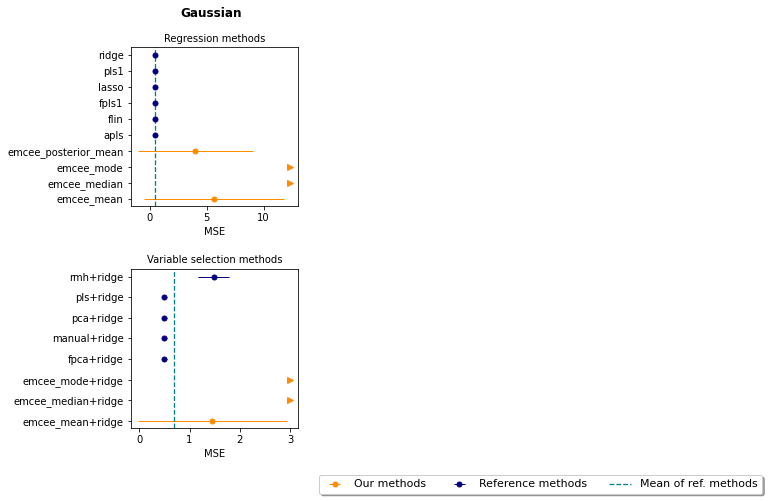

In [7]:
# -- Plot

print(
    "--> "
    + KIND.capitalize()
    + " " + METHOD
    + " " + data.upper()
    + (" (smooth)" if SMOOTHING else "")
    + " <--")

plot_data_all(
    data_all,
    limit=limit,
    legend=True,
    bbox_legend=bbox_legend,
    save=SAVE_FIG)

### Vertical plots

In [21]:
# -- Plotting functions

def plot_comparison(filename, data, top, kind):
    kernel_abbr = {
        "fractional": "fBM",
        "ornstein": "O-U",
        "squared": "RBF"
    }

    # Get info
    name = filename.split('_')
    if "kernel" in name:
        model = kernel_abbr[name[2]]
        kernel = True
    else:
        model = name[2]
        kernel = False

    if "BSpline" in filename:
        smoothing = "Base BSpline(16)"
    elif "Watson" in filename:
        smoothing = "Suavizado N-W"
    else:
        smoothing = "Sin suavizado"

    title = f"{model}" + (" kernel" if kernel else "") + f" - {smoothing}"

    # Get data
    emcee_data = data["emcee_best"][0]
    varsel_data = data["var_sel_best"][:top]
    sklearn_data = data["sk_best"][:top]

    n_sk = len(sklearn_data)
    n_emcee = 1
    n_varsel = len(varsel_data)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, 6), sharey=True)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    colors_sk = cm.Dark2.colors[:n_sk]
    colors_varsel = cm.Set1.colors[:n_varsel]

    ax1.scatter(
        np.zeros(n_sk), sklearn_data, marker="2",
        color=colors_sk, alpha=0.8, s=60, label="Comp.")
    ax1.set_xticks([])
    ax1.set_title("Comp.")
    if kind == "reg":
        ax1.set_ylabel("MSE")
    else:
        ax1.set_ylabel("Accuracy")

    ax2.set_title("Emcee")
    ax2.set_xticks([])
    ax2.scatter(
        np.zeros(n_varsel), varsel_data, marker="+",
        alpha=0.8, color=colors_varsel, s=50, label="Var. sel.")
    ax2.scatter(
        np.zeros(n_emcee), emcee_data, marker="*",
        alpha=1.0, s=80, color="r", label="MCMC")

    plt.suptitle(title)
    #plt.legend(bbox_to_anchor=(2.75, 1))
    plt.show()


def plot_all(rkhs, l2, real, top=5, kind="clf"):
    print(f" -----> RKHS ({kind}) <-----")
    for file in rkhs:
        data = np.load(f'out/{file}')
        filename = file[:-4]

        plot_comparison(filename, data, top, kind)

    print(f" -----> L2 ({kind}) <-----")
    for file in l2:
        data = np.load(f'out/{file}')
        filename = file[:-4]

        plot_comparison(filename, data, top, kind)

    print(f" -----> REAL ({kind}) <-----")
    for file in real:
        data = np.load(f'out/{file}')
        filename = file[:-4]

        plot_comparison(filename, data, top, kind)

 -----> RKHS (clf) <-----


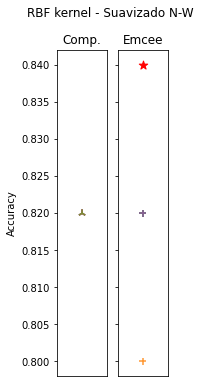

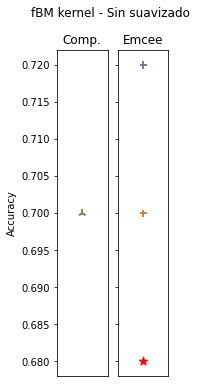

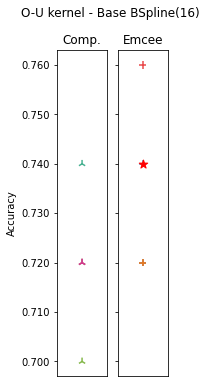

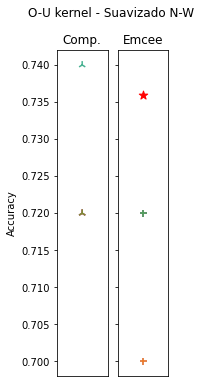

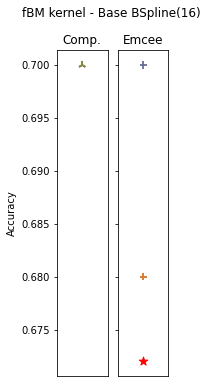

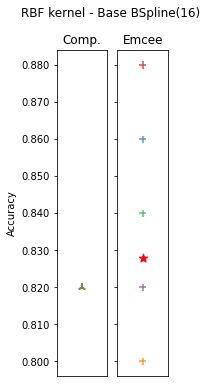

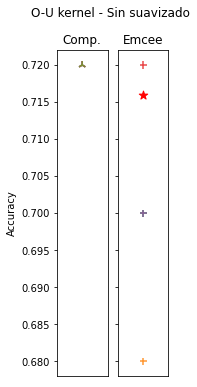

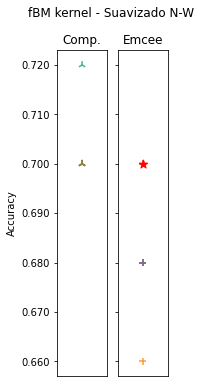

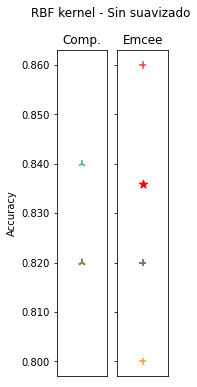

 -----> L2 (clf) <-----


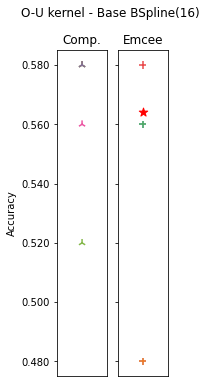

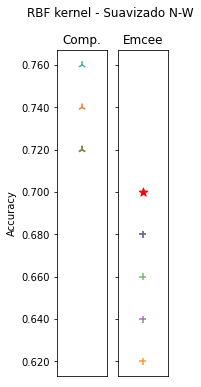

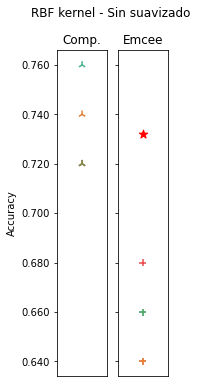

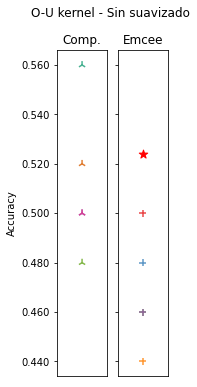

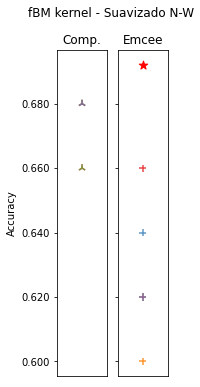

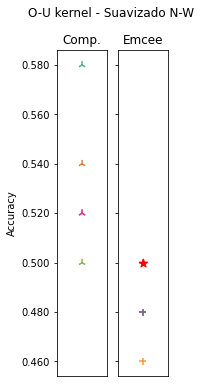

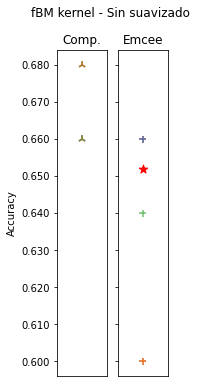

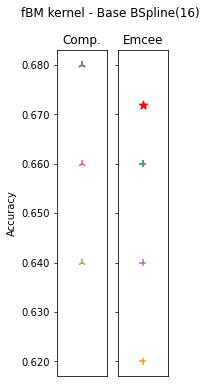

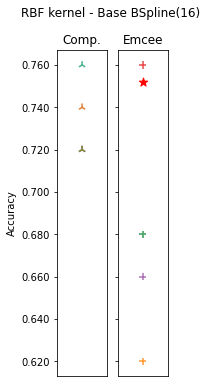

 -----> REAL (clf) <-----


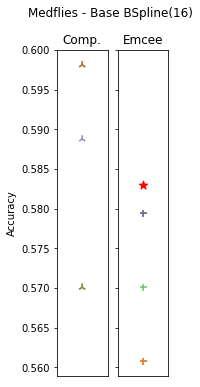

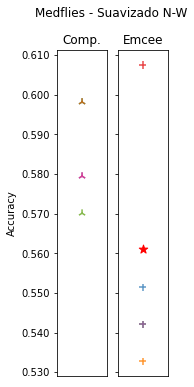

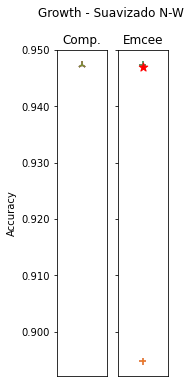

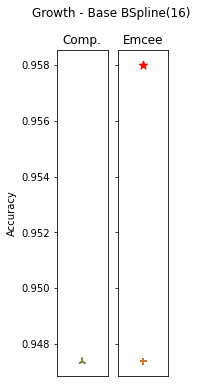

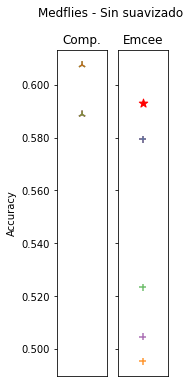

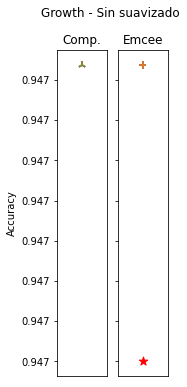

In [6]:
plot_all(rkhs_clf, l2_clf, real_clf, kind="clf")

## CV data

In [8]:
rkhs, l2, non_gp, real = get_filenames(DIR, extension="npz")

In [9]:
arr = np.load(rkhs[0] + ".npz", allow_pickle=True)

In [10]:
for a in arr.keys():
    print(a)

score_bayesian_all
score_var_sel_all


In [21]:
# Each row is a different rep, inside the arrays are # n_splits x params_shape
# e.g. for 5 folds, p in [2, 3] and eta in [0.01, 0.1], shape is (5, 2, 2).
arr["score_bayesian_all"]

array([{'posterior_mean': array([[[    -21.7756,     -21.7051,     -23.15  ,     -22.3542,
                    -23.0897],
               [    -17.1288,     -14.5153,     -14.2585,     -15.4653,
                    -18.8007],
               [    -18.8613,     -16.7645,     -15.8601,     -19.0107,
                    -19.9088],
               [    -19.4397,     -20.9921,     -19.0508,     -18.1456,
                    -21.5141],
               [     -0.4776,      -0.6197,      -0.4765,      -0.5573,
                     -1.461 ],
               [     -0.505 ,      -0.5347,      -0.466 ,      -0.4404,
                     -2.3674],
               [     -2.2613,      -1.1663,      -0.9431,      -0.9481,
                     -5.8375],
               [     -4.9262,      -5.1995,      -8.5992,      -6.11  ,
                    -39.6897],
               [    -14.6555,      -9.5592,      -1.3813,     -10.769 ,
                    -66.657 ],
               [    -34.8659,     -21.5789,     -33.92

In [43]:
first = arr["score_var_sel_all"][5]
first_pm = first['mode']
first_pm.shape # (n_splits x p x eta)

(5, 10, 5)

In [44]:
v=first_pm.mean(axis=0)  # (p x eta)

In [45]:
v

array([[-24.5425, -24.5546, -24.5546, -24.5425, -24.0626],
       [ -5.4506,  -6.6402, -13.686 ,  -5.3561,  -9.2882],
       [ -6.7758,  -6.8513,  -6.9292,  -6.7261,  -7.4653],
       [ -6.3287,  -7.0321,  -0.9293,  -7.0315,  -2.1218],
       [ -6.1771, -10.7925,  -6.5426, -11.3419,  -7.5694],
       [ -6.5008,  -5.9907,  -6.0185, -11.2993,  -5.8855],
       [ -5.5053,  -6.4375,  -0.9558,  -1.2602,  -3.0912],
       [ -4.0983,  -1.0513,  -5.7255,  -1.0172,  -0.5402],
       [ -0.6145,  -8.6833, -19.946 , -16.466 ,  -1.0683],
       [ -6.7504, -10.1104, -31.0264, -15.0451,  -0.6153]])

In [33]:
np.unravel_index(v.argmax(), v.shape)

(5, 0)